In [ ]:
# To-Do
#1)

In [1]:
# Import the needed libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import os 

from tensorflow.keras import datasets, layers, models

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2, l1
from keras.utils import normalize, to_categorical
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)

import sys
sys.path.insert(0, '/home/btannenw/Desktop/ML/dihiggsMLProject/')
from utils.commonFunctions import *

Using TensorFlow backend.


In [2]:
# Get image data
hh_h5  = h5.File('/home/btannenw/Desktop/ML/dihiggsMLProject/convolutionalNN/test_pp2hh4b_25k_composite_15pixel/images/test_pp2hh4b_25k_composite_15pixel_allImages.h5', 'r')
qcd_h5 = h5.File('/home/btannenw/Desktop/ML/dihiggsMLProject/convolutionalNN/test_ppTo4b_50k_composite_15pixel/images/test_ppTo4b_50k_composite_15pixel_allImages.h5', 'r')

In [ ]:
# Make composite dihiggs images
#hh_combImages = []
##for iEvt in range(0, len(hh_imgs['trackImgs'])):
#for iEvt in range(0, 5000):
#    if iEvt%500 == 0:
#        print('Processed {} dihiggs events'.format(iEvt) )
#    hh_combImages.append( np.stack( (hh_imgs['trackImgs'][iEvt], hh_imgs['nHadronImgs'][iEvt], hh_imgs['photonImgs'][iEvt]), axis=-1) )
#print(len(hh_combImages))

#hh = np.stack( (hh_combImages), axis=0)

In [8]:
# Read data
nEvents = 24000
hh = hh_h5['compositeImgs'][:nEvents]
qcd = qcd_h5['compositeImgs'][:nEvents]

#hh_4j = hh_h5['compositeImgs_4j']
#qcd_4j = qcd_h5['compositeImgs_4j']

#hh_4j
#hh  = np.asarray( [ img for img, njets in zip(hh_h5['compositeImgs'], hh_h5['nJets']) if njets >= 4 ] )
#qcd  = np.asarray( [ img for img, njets in zip(qcd_h5['compositeImgs'], qcd_h5['nJets']) if njets >= 4 ] )
#hh  = np.asarray( [ img for img in hh_h5['compositeImgs'] ] )
#qcd  = np.asarray( [ img for img in qcd_h5['compositeImgs'] ] )


#hh = []
#nEvts = len(hh_h5['nJets'])
#for iEvt in range(0, nEvts):
#    if (100*(iEvt+1)/nEvts)%10 == 0:
#        print( 'Processed {}% hh...'.format( (100*(iEvt+1))/nEvts))
#    if hh_h5['nJets'][iEvt]>3:
#        hh.append(hh_h5['compositeImgs'][iEvt])

#print(len(hh), len(qcd), len(hh_4j), len(qcd_4j))

24000 24000 24980 49925


In [10]:
plt.hist( [sum(img) for img in hh_4j])

KeyboardInterrupt: 

In [13]:
#nEvents = min(len(hh), len(qcd))
#nEvents = min(len(hh_imgs['compositeImgs']), len(qcd_imgs['compositeImgs']))

# Make labels
hh_labels = np.ones( nEvents )
qcd_labels = np.zeros( nEvents )
nEvents_4j = min( len(hh_4j), len(qcd_4j))
#hh_4j_labels = np.ones( nEvents_4j )
#qcd_4j_labels = np.zeros( nEvents_4j )

# Make combined dataset
all_images = np.concatenate ( (hh.copy(), qcd.copy()), axis=0)
all_labels = np.concatenate ( (hh_labels.copy(), qcd_labels.copy()), axis=0)
print(all_images.shape, all_labels.shape)

#all_4j_images = np.concatenate ( (hh_4j.copy(), qcd_4j.copy()), axis=0)
#all_4j_labels = np.concatenate ( (hh_4j_labels.copy(), qcd_4j_labels.copy()), axis=0)
#print(all_images.shape, all_labels.shape)

#all_images, all_labels = shuffle(all_images, all_labels, random_state=0)
imgs_train, imgs_test, labels_train, labels_test = train_test_split(all_images, all_labels, test_size=0.1, shuffle= True, random_state=30)
#imgs_4j_train, imgs_4j_test, labels_4j_train, labels_4j_test = train_test_split(all_4j_images, all_4j_labels, test_size=0.1, shuffle= True, random_state=30)

(48000, 15, 15, 3) (48000,)


In [24]:
# Layer options
l2_reg = tf.keras.regularizers.l2(1e-4)
conv_kwargs = dict(
            activation="relu",
            #kernel_initializer=tf.keras.initializers.lecun_normal(),
            kernel_regularizer=l2_reg,
    )

dense_kwargs = conv_kwargs

# Define model
model = Sequential()

# Convolutional part
model.add( Conv2D(16, (3, 3), input_shape=(15, 15, 3), **conv_kwargs) )
model.add( MaxPooling2D((2, 2)) )
#model.add( Conv2D(32, (3, 3), activation='relu'))
#model.add( MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Feed-forward part
model.add( Flatten())
model.add( Dense(64, **dense_kwargs))
model.add( BatchNormalization() )
model.add( Dense(64, **dense_kwargs))
#model.add( Dropout(0.2) )
model.add( Dense(1) )


In [25]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 13, 13, 16)        448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                36928     
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                

In [26]:
metrics = [ #tf.keras.metrics.categorical_accuracy,
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
    ]

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=metrics)
              #metrics=['accuracy'])

In [27]:
# *** 1. Define output directory
topDir = "composite_pixel15"
name = 'epochs40'
if not os.path.exists(topDir):
    os.makedirs(topDir)
model_dir = os.path.join(topDir, "", "models", name)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# *** 2. Define callbacks for training
fit_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(model_dir, name)+'.hdf5',
            save_best_only=True,
            save_weights_only=True,
            #monitor="val_auc",
            #mode="max",
            monitor="val_loss",
            mode="min",
        ),
    tf.keras.callbacks.EarlyStopping(
            #monitor="val_auc",
            #mode="max",
            monitor='val_loss', 
            mode='min', 
            verbose=1, 
            patience=10,  
            min_delta=.0025,
        ),
    ]
    
history = model.fit(imgs_train, labels_train, epochs=40, 
                    shuffle=True,
                    batch_size=512,
                    validation_data=(imgs_test, labels_test),
                    callbacks=fit_callbacks
                   )

Train on 43200 samples, validate on 4800 samples
Epoch 1/40
43200/43200 [==============================] - 5s 116us/step - loss: 1.3521 - accuracy: 0.5609 - auc: 0.3788 - val_loss: 1.0549 - val_accuracy: 0.4958 - val_auc: 0.4851
Epoch 2/40
43200/43200 [==============================] - 5s 109us/step - loss: 0.7088 - accuracy: 0.6209 - auc: 0.5231 - val_loss: 0.8994 - val_accuracy: 0.4958 - val_auc: 0.5514
Epoch 3/40
43200/43200 [==============================] - 4s 100us/step - loss: 0.7158 - accuracy: 0.6325 - auc: 0.5680 - val_loss: 0.8127 - val_accuracy: 0.4958 - val_auc: 0.5781
Epoch 4/40
43200/43200 [==============================] - 5s 120us/step - loss: 0.6937 - accuracy: 0.6327 - auc: 0.5862 - val_loss: 0.7645 - val_accuracy: 0.4958 - val_auc: 0.5954
Epoch 5/40
43200/43200 [==============================] - 5s 115us/step - loss: 1.0921 - accuracy: 0.5938 - auc: 0.5986 - val_loss: 0.9077 - val_accuracy: 0.4871 - val_auc: 0.5933
Epoch 6/40
43200/43200 [===========================

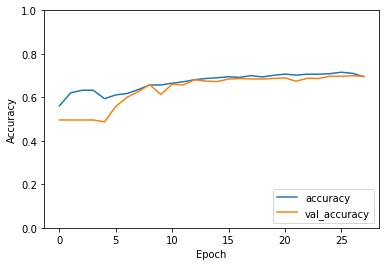

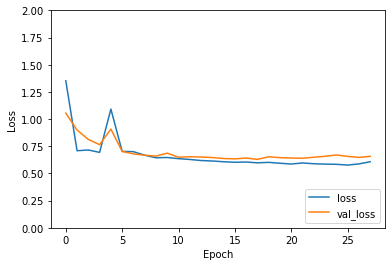

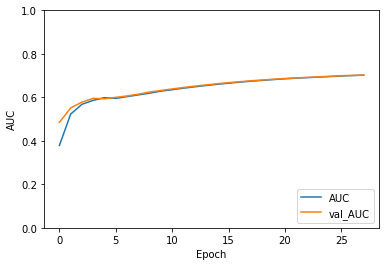

In [28]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0., 2])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['auc'], label='AUC')
plt.plot(history.history['val_auc'], label = 'val_AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.ylim([0., 1])
plt.legend(loc='lower right')
plt.show()

#test_loss, test_acc = model.evaluate(imgs_test,  labels_test, verbose=2)


In [29]:
# make prediction data
hh_data_test    = np.asarray([x for x,y in zip(imgs_test, labels_test) if y==1])
hh_labels_test  = np.asarray([y for x,y in zip(imgs_test, labels_test) if y==1])
qcd_data_test   = np.asarray([x for x,y in zip(imgs_test, labels_test) if y==0])
qcd_labels_test = np.asarray([y for x,y in zip(imgs_test, labels_test) if y==0])

#load model 

# make predictions
score_hh = model.evaluate(hh_data_test, hh_labels_test)
score_qcd = model.evaluate(qcd_data_test, qcd_labels_test)
print(score_hh, score_qcd)
pred_hh = model.predict(hh_data_test)
pred_qcd = model.predict(qcd_data_test)

2380/2380 [==============================] - 0s 158us/step
[0.5639351506863743, 0.7371900677680969, 0.7027792930603027] [0.7525384931003346, 0.6550419926643372, 0.7028436064720154]


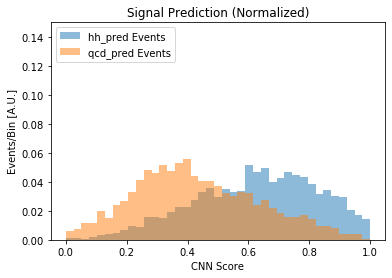

In [30]:
_nBins = 40
predictionResults = {'hh_pred':pred_hh, 'qcd_pred':pred_qcd}
compareManyHistograms( predictionResults, ['hh_pred', 'qcd_pred'], 2, 'Signal Prediction', 'CNN Score', 0, 1, _nBins, _yMax = 5, _normed=True, savePlot=False )


In [31]:
# *** 4. Get best cut value for CNN assuming some minimal amount of signal
pred_hh_sig = [x[0] for x in pred_hh.copy()]
pred_qcd_sig = [x[0] for x in pred_qcd.copy()]

returnBestCutValue('CNN', pred_hh_sig, pred_qcd_sig, _minBackground=400e3, _testingFraction=0.1)

2420 2380
nSig = 1093.12 , nBkg = 3532718.67 with significance = 0.582 +/- 0.02 for CNN score > 0.595


(0.5815843050386775, 0.5954786268147555, 0.019700769834717188)

In [34]:
# *** 6B. Get signifiance for any user-specified NN score cut value
testingFraction = 0.1
lumiscale_hh  = getLumiScaleFactor(testingFraction, True, 25e3)
lumiscale_qcd = getLumiScaleFactor(testingFraction, False, 50e3)
cut = 0.48
_nSignal = sum( value > cut for value in pred_hh_sig)*lumiscale_hh
_nBackground = sum( value > cut for value in pred_qcd_sig)*lumiscale_qcd

print('nSig = {0} , nBkg = {1} with significance = {2} for NN score > {3}'.format(_nSignal, _nBackground, _nSignal/np.sqrt(_nBackground), cut) )

nSig = 1366.0271999999998 , nBkg = 5985074.97 with significance = 0.5583731795825618 for NN score > 0.48


In [35]:
(1e6/25e3)/np.sqrt(4e6/50e3)

4.47213595499958

In [37]:
(1093*(1e6/25e3))/np.sqrt(3532718*(4e6/50e3))

2.6006426116119927

In [39]:
0.02*np.sqrt(2)

0.028284271247461905